## Useful codes and functions for Tutorial 3

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal

In [13]:
df = pd.read_csv('/content/data/dataset1-2.csv')
data = df['Value']
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Value
0,2023-09-12,0.319383
1,2023-09-13,0.373839
2,2023-09-14,0.447583
3,2023-09-15,-0.252889
4,2023-09-16,-0.468198


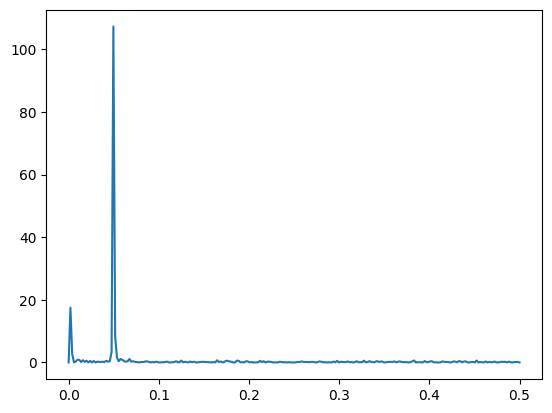

In [14]:
frequencies, power_spectrum = signal.periodogram(data, fs=1)
plt.plot(frequencies, power_spectrum)

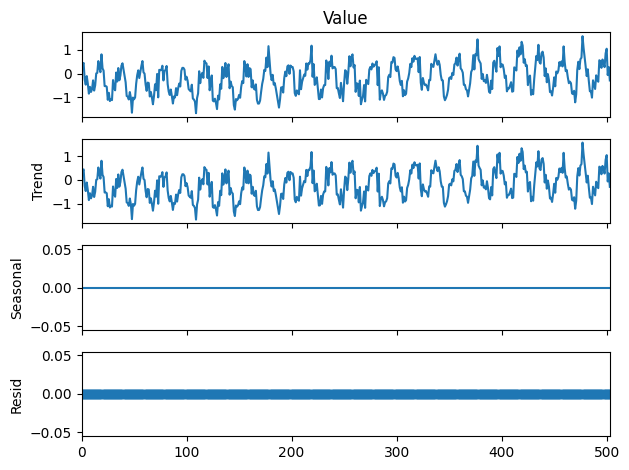

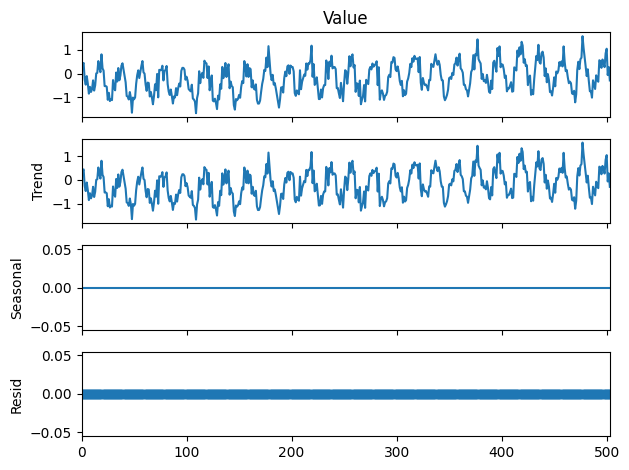

In [53]:
period = 1 # change as needed

result_season_trend = seasonal_decompose(data, model='Additive', period=period)
result_season_trend.plot()

In [54]:
# Extract seasonal ingredients
seasonal = result_season_trend.seasonal

# Assuming the last known time point is t, the goal is to predict the seasonal trend at t+1
last_seasonal = seasonal.iloc[-1]  # Seasonal components at the current point in time
next_seasonal = seasonal.iloc[0]  # Post-cycle prediction (assuming full seasonality of cycles)

print(f"Last seasonal component: {last_seasonal}")
print(f"Predicted seasonal component for next period: {next_seasonal}")

# Determine the direction of pt
if next_seasonal > 0:
    print("Predicted log-price (based on seasonality) will be > 0 on 23/02/2025.")
else:
    print("Predicted log-price (based on seasonality) will be < 0 on 23/02/2025.")


Last seasonal component: 0.0
Predicted seasonal component for next period: 0.0
Predicted log-price (based on seasonality) will be < 0 on 23/02/2025.


In [57]:
# ARMA model fitted (based on the best p, q values previously chosen)
p, q = 2, 2  # the best parameters found in the end of this code
model = ARIMA(data, order=(p, 0, q))
model_fit = model.fit()

# Generate 1-step forecasts
forecast_result = model_fit.get_forecast(steps=1)
forecast_mean = forecast_result.predicted_mean.iloc[0]
forecast_conf_int = forecast_result.conf_int()

print(f"Forecasted Mean (ARMA): {forecast_mean}")
print(f"95% Confidence Interval: {forecast_conf_int}")


Forecasted Mean (ARMA): -0.3335783458518832
95% Confidence Interval:      lower Value  upper Value
504     -0.99174     0.324583


In [59]:
# Price Table
bet_prices = {
    "Up": 0.16,
    "Down": 0.84,
    "In Range": 0.77,
    "Out of Range": 0.23
}

# Define the expected return calculated before
expected_profits = {
    "Up": expected_up,
    "Down": expected_down,
    "In Range": expected_in_range,
    "Out of Range": expected_out_range
}

# Calculation of net expected return
net_expected_profit = {bet: expected_profits[bet] - bet_prices[bet] for bet in bet_prices}

# Sort by net income
sorted_bets = sorted(net_expected_profit.items(), key=lambda x: x[1], reverse=True)

# Output sorting results
print("Sorted Bets by Net Expected Profit:")
for bet, profit in sorted_bets:
    print(f"{bet}: Net Expected Profit = {profit:.4f}, Cost = {bet_prices[bet]:.2f}")

# Filter optimal bets (select up to two)
selected_bets = sorted_bets[:2]

# Output Final Selection
print("\nSelected Bets:")
for bet, profit in selected_bets:
    print(f"{bet}: Net Expected Profit = {profit:.4f}, Cost = {bet_prices[bet]:.2f}")


Sorted Bets by Net Expected Profit:
Out of Range: Net Expected Profit = 0.4827, Cost = 0.23
Up: Net Expected Profit = 0.0754, Cost = 0.16
Down: Net Expected Profit = -0.4672, Cost = 0.84
In Range: Net Expected Profit = -1.1266, Cost = 0.77

Selected Bets:
Out of Range: Net Expected Profit = 0.4827, Cost = 0.23
Up: Net Expected Profit = 0.0754, Cost = 0.16


In [60]:
# Extracting the residuals
residuals = model_fit.resid


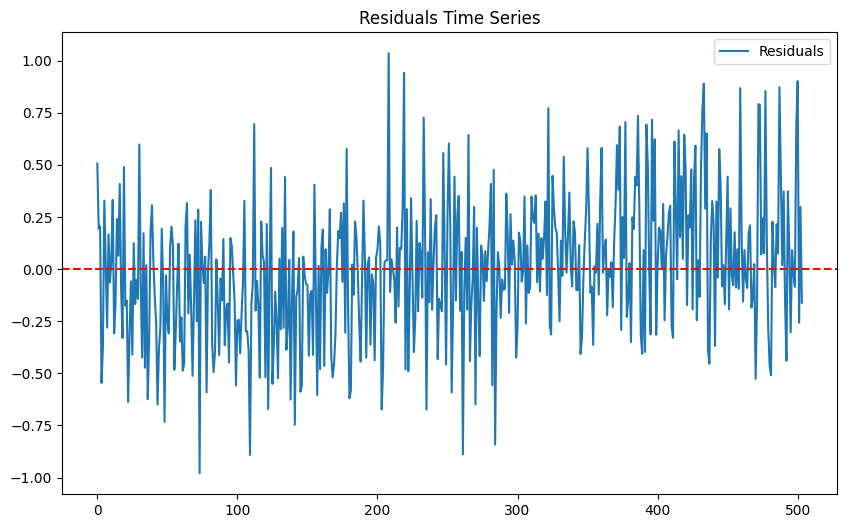

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residuals Time Series")
plt.legend()
plt.show()


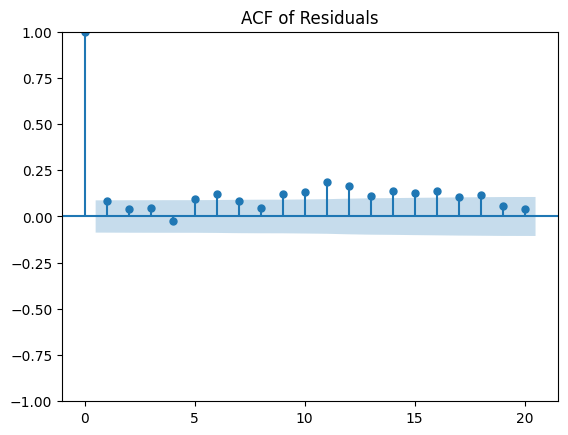

In [62]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals, lags=20, title="ACF of Residuals")
plt.show()


In [63]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)


      lb_stat  lb_pvalue
10  38.720207   0.000028


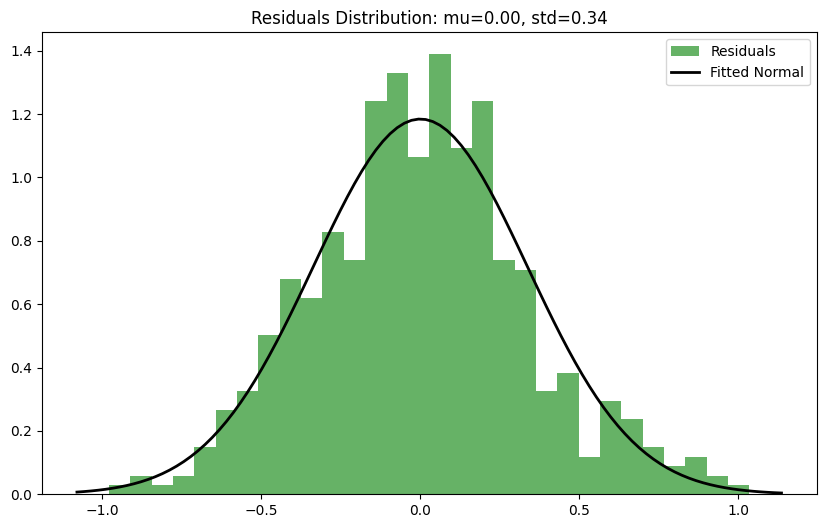

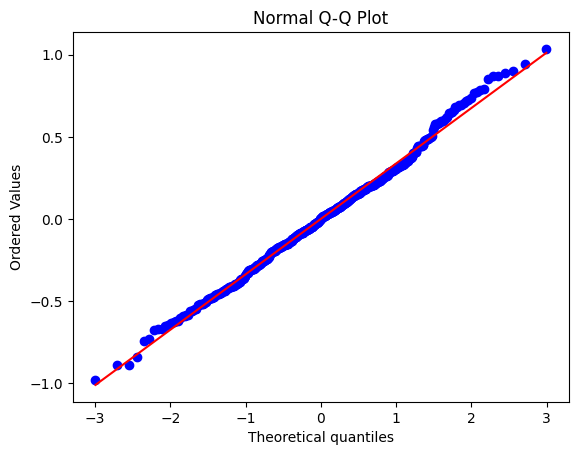

In [64]:
from scipy.stats import norm, probplot

# Plotting histograms
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, density=True, alpha=0.6, color="g", label="Residuals")
mu, std = norm.fit(residuals)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, "k", linewidth=2, label="Fitted Normal")
plt.title(f"Residuals Distribution: mu={mu:.2f}, std={std:.2f}")
plt.legend()
plt.show()

# Plotting a normal Q-Q graph
probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")
plt.show()


In [21]:
from statsmodels.tsa.arima.model import ARIMA

# Choose the ARMA(p,q) model order (p, q)
p = 1 # AR order
q = 1 # MA order

# Fitting the ARIMA model
model = ARIMA(df['Value'], order=(p, 0, q))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  504
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -247.798
Date:                Tue, 28 Jan 2025   AIC                            503.597
Time:                        12:18:27   BIC                            520.487
Sample:                             0   HQIC                           510.222
                                - 504                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1799      0.085     -2.106      0.035      -0.347      -0.012
ar.L1          0.8312      0.034     24.666      0.000       0.765       0.897
ma.L1         -0.1814      0.067     -2.690      0.0

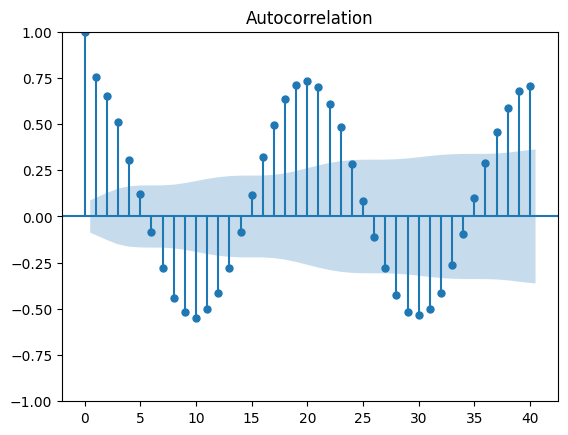

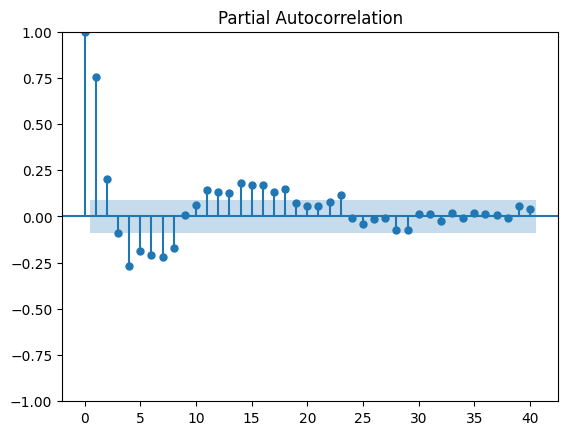

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Mapping ACF and PACF
plot_acf(df['Value'], lags=40)
plt.show()

plot_pacf(df['Value'], lags=40)
plt.show()

In [46]:
import itertools
from statsmodels.tsa.arima.model import ARIMA

# Define the range of p and q
p_values = range(0, 3)  # AR order
q_values = range(0, 3)  # MA order

# Initialising the optimal model parameters
best_aic = float('inf')
best_bic = float('inf')
best_hqic = float('inf')
best_order = None

# Iterate over all possible combinations of (p, q)
for p, q in itertools.product(p_values, q_values):
    try:
        model = ARIMA(df['Value'], order=(p, 0, q))
        model_fit = model.fit()
        aic = model_fit.aic
        bic = model_fit.bic
        hqic = model_fit.hqic

        # Select the model with the smallest AIC
        if aic < best_aic:
            best_aic = aic
            best_order = (p, q)

        # Select the model with the smallest BIC
        if bic < best_bic:
            best_bic = bic
            best_order_bic = (p, q)

        # Select the model with the smallest HQIC
        if hqic < best_hqic:
            best_hqic = hqic
            best_order_hqic = (p, q)

    except:
        continue

print(f"Best ARMA(p,q) based on AIC: {best_order} with AIC={best_aic}")
print(f"Best ARMA(p,q) based on BIC: {best_order_bic} with BIC={best_bic}")
print(f"Best ARMA(p,q) based on HQIC: {best_order_hqic} with HQIC={best_hqic}")

Best ARMA(p,q) based on AIC: (2, 2) with AIC=345.654307010035
Best ARMA(p,q) based on BIC: (2, 2) with BIC=370.9897646184632
Best ARMA(p,q) based on HQIC: (2, 2) with HQIC=355.59251515410614


In [30]:
from statsmodels.tsa.arima.model import ARIMA

# Choose the order of the ARMA(p,q) model (p, q)
p = 2  # AR order
q = 2  # MA order

# Fitting the ARIMA model
model = ARIMA(df['Value'], order=(p, 0, q))
model_fit = model.fit()

# Summary of output models
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  504
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -166.827
Date:                Tue, 28 Jan 2025   AIC                            345.654
Time:                        12:26:07   BIC                            370.990
Sample:                             0   HQIC                           355.593
                                - 504                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1869      0.027     -6.931      0.000      -0.240      -0.134
ar.L1          1.8804      0.012    162.771      0.000       1.858       1.903
ar.L2         -0.9767      0.011    -88.472      0.0

In [42]:
forecast = model_fit.forecast(steps=1)

print("Forecasted Value:", forecast.values[0])

forecast_result = model_fit.get_forecast(steps=1)

forecast_mean = forecast_result.predicted_mean.iloc[0]

forecast_se = forecast_result.se_mean.iloc[0]

print("Forecasted Mean:", forecast_mean)
print("Forecasted Standard Deviation (std):", forecast_se)



Forecasted Value: -0.4282935311386613
Forecasted Mean: -0.4282935311386613
Forecasted Standard Deviation (std): 0.3344580623024213
